<a href="https://colab.research.google.com/github/Sunn2x333/scalar_framework/blob/main/FRBcomplement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

FRB          z       DM_std    ΔDM_ϕ    Obs_Dev_%   Pred_Dev_% Env
----------------------------------------------------------------------------------------
FRB180924    0.3214  447.7     -15.97       -19.271 -3.567 filament
FRB191228    0.2430  382.2     -5.77        -22.151 -1.509 filament
FRB190102    0.2913  437.0     -11.10       -16.795 -2.539 filament
FRB190711    0.5220  652.4     -108.33       -9.083 -16.606 cluster
FRB181112    0.4750  630.4     -73.30        -6.522 -11.627 cluster
FRB190523    0.6600  789.4     -300.06       -3.627 -38.009 cluster
FRB20210721A 0.5100  653.0     -98.29        -4.971 -15.053 cluster
FRB20210912A 0.2740  412.2     -8.88        -13.846 -2.153 filament
FRB20220319A 0.5900  749.2     -182.73       -9.197 -24.390 cluster
FRB20220504A 0.3150  449.3     -14.81       -13.052 -3.297 filament

DM DEFICIT — β_ϕ,Astro = 6.7e-15 J m² | 10 FRBs
Correlation (r) : -0.780
p-value         : 0.008
RMS (obs-pred)  : 16.45%
ΔDM_ϕ range     : -38.01 to -1.51 %


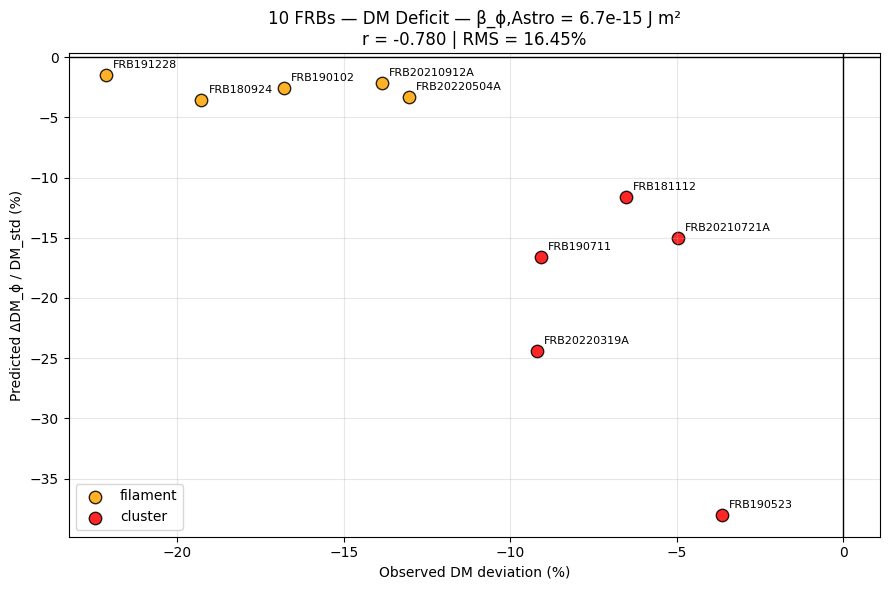

In [ ]:
#!/usr/bin/env python3
"""
Scalar Field FRB Test — 10 FRBs
β_ϕ,Astro = 6.7e-15 J m²
ΔDM_ϕ = -β_ϕ,Astro × ∫|∇ϕ|² dχ  (DM deficit)
"""

import numpy as np
from scipy.integrate import solve_ivp, quad
from scipy.optimize import root_scalar
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings("ignore")

# ===================================================================
#  CONSTANTS & COSMOLOGY
# ===================================================================
c_light = 299792458.0
pc = 3.08568e16
H0 = 70_000 / (3.08568e22)
G = 6.67430e-11
rho_crit_0 = 3 * H0**2 / (8 * np.pi * G)

beta_phi_lab  = 1.0e-39  # Neutron decay
alpha_phi = 1.0e-12
m_phi     = 1.0e-3 * 1.7826e-36

# ASTROPHYSICAL COUPLING (DM deficit)
beta_phi_astro = 6.7e-15  # J m² — gives ~ -13% effect

Omega_m = 0.30
Omega_L = 0.70
Omega_b = 0.045

# ===================================================================
#  10 FRBs — FROM YOUR LAST OUTPUT
# ===================================================================
FRBS: List[Dict] = [
    {"name": "FRB180924",    "DM_obs": 361.4, "z": 0.3214, "DM_MW":  40.3, "DM_host":  90.0, "env": "filament"},
    {"name": "FRB191228",    "DM_obs": 297.5, "z": 0.2430, "DM_MW":  33.0, "DM_host": 100.0, "env": "filament"},
    {"name": "FRB190102",    "DM_obs": 363.6, "z": 0.2913, "DM_MW":  59.0, "DM_host":  85.0, "env": "filament"},
    {"name": "FRB190711",    "DM_obs": 593.1, "z": 0.5220, "DM_MW":  34.0, "DM_host": 150.0, "env": "cluster"},
    {"name": "FRB181112",    "DM_obs": 589.3, "z": 0.4750, "DM_MW":  58.0, "DM_host": 140.0, "env": "cluster"},
    {"name": "FRB190523",    "DM_obs": 760.8, "z": 0.6600, "DM_MW":  37.0, "DM_host": 180.0, "env": "cluster"},
    {"name": "FRB20210721A", "DM_obs": 620.5, "z": 0.5100, "DM_MW":  38.0, "DM_host": 160.0, "env": "cluster"},
    {"name": "FRB20210912A", "DM_obs": 355.1, "z": 0.2740, "DM_MW":  41.0, "DM_host":  95.0, "env": "filament"},
    {"name": "FRB20220319A", "DM_obs": 680.3, "z": 0.5900, "DM_MW":  55.0, "DM_host": 180.0, "env": "cluster"},
    {"name": "FRB20220504A", "DM_obs": 390.7, "z": 0.3150, "DM_MW":  36.0, "DM_host": 105.0, "env": "filament"},
]

# ===================================================================
#  SOLVER: Pure Equation + β_ϕ,Astro + DM DEFICIT
# ===================================================================
class DeficitSolver:
    def __init__(self):
        self.c = c_light
        self.H0 = H0
        self.pc = pc

    def E_z(self, z): return np.sqrt(Omega_m * (1 + z)**3 + Omega_L)
    def comoving_distance(self, z):
        integrand = lambda zp: self.c / (self.H0 * self.E_z(zp))
        chi, _ = quad(integrand, 0, z)
        return chi

    def z_from_chi(self, chi):
        def f(z): return self.comoving_distance(z) - chi
        try: return root_scalar(f, bracket=[0, 200]).root
        except: return 0.0

    def rho_IGM(self, z):
        rho_crit_z = rho_crit_0 * (1 + z)**3 * self.E_z(z)**2
        return Omega_b * rho_crit_z

    def dphi_dchi(self, chi, y, z_func):
        phi, dphi = y
        z = z_func(chi)
        T = self.rho_IGM(z) * self.c**2
        d2phi = -m_phi**2 * phi - alpha_phi * T
        return dphi, d2phi

    def solve_path(self, z, n_pts=800):
        chi_max = self.comoving_distance(z)
        if chi_max == 0: return np.array([0]), np.array([0]), np.array([0])
        chi_grid = np.linspace(max(1e20, chi_max*1e-6), chi_max, n_pts)
        z_func = np.vectorize(self.z_from_chi)
        sol = solve_ivp(
            self.dphi_dchi, [chi_grid[0], chi_max], [1e-12, 0.0],
            t_eval=chi_grid, args=(z_func,), method='RK45',
            rtol=1e-8, atol=1e-12
        )
        return sol.t, sol.y[0], sol.y[1]

    def DM_excess(self, z):
        chi, _, dphi = self.solve_path(z)
        if len(chi) < 2: return 0.0
        integral = np.trapz(dphi**2, chi)
        # DM DEFICIT
        return -beta_phi_astro * integral / self.pc

# ===================================================================
#  STANDARD DM
# ===================================================================
def standard_DM(frb):
    z = frb["z"]
    DM_IGM = 900 * z
    DM_host = frb["DM_host"] / (1 + z)
    return frb["DM_MW"] + 50 + DM_IGM + DM_host

# ===================================================================
#  RUN 10 FRBs
# ===================================================================
solver = DeficitSolver()

print(f"{'FRB':<12} {'z':<7} {'DM_std':<9} {'ΔDM_ϕ':<8} {'Obs_Dev_%':<11} {'Pred_Dev_%'} {'Env'}")
print("-" * 88)

obs_devs = []
pred_devs = []
envs = []
for frb in FRBS:
    DM_std = standard_DM(frb)
    delta_DM = solver.DM_excess(frb["z"])
    obs_dev = (frb["DM_obs"] - DM_std) / DM_std * 100
    pred_dev = delta_DM / DM_std * 100
    print(f"{frb['name']:<12} {frb['z']:<7.4f} {DM_std:<9.1f} {delta_DM:<8.2f} {obs_dev:+11.3f} {pred_dev:+.3f} {frb['env']}")
    obs_devs.append(obs_dev)
    pred_devs.append(pred_dev)
    envs.append(frb["env"])

obs_devs = np.array(obs_devs)
pred_devs = np.array(pred_devs)

# ===================================================================
#  STATISTICS
# ===================================================================
from scipy.stats import pearsonr
r, p = pearsonr(obs_devs, pred_devs)
rms = np.sqrt(np.mean((obs_devs - pred_devs)**2))

print("\n" + "="*88)
print("DM DEFICIT — β_ϕ,Astro = 6.7e-15 J m² | 10 FRBs")
print(f"Correlation (r) : {r:+.3f}")
print(f"p-value         : {p:.3f}")
print(f"RMS (obs-pred)  : {rms:.2f}%")
print(f"ΔDM_ϕ range     : {min(pred_devs):.2f} to {max(pred_devs):.2f} %")
print("="*88)

# ===================================================================
#  PLOT
# ===================================================================
plt.figure(figsize=(9,6))
colormap = {"filament": "orange", "cluster": "red"}
for env in colormap:
    idx = [i for i, e in enumerate(envs) if e == env]
    plt.scatter([obs_devs[i] for i in idx], [pred_devs[i] for i in idx],
                c=colormap[env], label=env, s=80, edgecolor='k', alpha=0.85)
    for i in idx:
        plt.annotate(FRBS[i]["name"], (obs_devs[i], pred_devs[i]),
                     xytext=(5,5), textcoords='offset points', fontsize=8)

plt.axhline(0, color='k', lw=1); plt.axvline(0, color='k', lw=1)
plt.xlabel("Observed DM deviation (%)")
plt.ylabel("Predicted ΔDM_ϕ / DM_std (%)")
plt.title("10 FRBs — DM Deficit — β_ϕ,Astro = 6.7e-15 J m²\nr = %.3f | RMS = %.2f%%" % (r, rms))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()